In [1]:

import pandas as pd
import numpy as np
import time
import pickle
import os
import scipy.stats as stats
import sigfig as sf

import helper_functions as hf
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
tfCore='NWNNGANA'
all8merSeqsPossible=hf.IupacToAllPossibleSequences(tfCore)

all8merSeqsPossible+=[hf.revcomp(seq) for seq in all8merSeqsPossible]
print(all8merSeqsPossible[:3])

tfName='IRF3'

['AAAAGAAA', 'AAAAGACA', 'AAAAGAGA']


In [3]:
def getAll8mers(seq,p,ref,alt):
    
    altLenAdj=len(ref)-len(alt)
      
    if p<8:
        # print(0)
        seq=seq[:p+8]
        seqRef=seq[:p]+ref+seq[p+1:]
        seqAlt=seq[:p]+alt+seq[p+1:]
        
#         print(seq)
#         print(seqRef)
#         print(seqAlt)
    
    elif altLenAdj==0:
        # print(1)
        seq=seq[p-7:p+8]    
        seqRef=seq[:7]+ref+seq[7+1:]
        seqAlt=seq[:7]+alt+seq[7+1:]
        
        # print(seq)
        # print(seqRef)
        # print(seqAlt)
        
    elif altLenAdj>0:
        # print(2)
        seq=seq[p-7:p+8+altLenAdj]    
        seqRef=seq[:7]+ref+seq[7+1:-altLenAdj]
        seqAlt=seq[:7]+alt+seq[7+1:]
    else:
        # print(3)
        raise ValueError('ref/alt not allowed yet')
    
    # if len(seqRef)!=len(seqAlt):
        # raise ValueError('ref/alt seqs not dovetailed')
        
    for i,end in enumerate(range(7,len(seq)-altLenAdj)):
        # print(4)
        start=end-7
        last=end+1
        kmer8Ref=seqRef[start:last]
        kmer8Alt=seqAlt[start:last]
            
        yield kmer8Ref,kmer8Alt


In [4]:
def is_seq_tfsite_match(kmer8):
    if kmer8 in all8merSeqsPossible: return True
    else:                    return False

# Set up logic for creating/deleting ets sites
BeforeAfter2TfLogic={
    (0,0):'Tf Never',
    (1,1):'Tf Always',
    (0,1):'Tf Created',
    (1,0):'Tf Deleted'
}

In [5]:

def snv_tf_analysis(chrom,idx1,ref,alt,chr2seq,tf2aff):
    
    # Ensure data is snp, no indels
    prohibitedPolyTypes=['Other']
    if len(ref)==1 and len(alt)==1: 
        polymorphismType='SNV'
        
    elif len(ref)==1 and len(alt)==0:
        polymorphismType='SND'
        
    else:
        polymorphismType='Other'
        
    if polymorphismType in prohibitedPolyTypes:
        return 'Variant Type Not Allowed Yet'
        
    ######################################
    # Verify ref/alt matches genomic bp
    ######################################
    
    # if 'chr' not in chrom: chrom=f'chr{chrom}'
    
    # Check if pos in genome is same as declared REF
    idx0=int(idx1)#-1
    snvNtInGenome=chr2seq[chrom][idx0]
    if ref==snvNtInGenome:    
        checkSnv='REF'
    elif alt==snvNtInGenome:  
        checkSnv='ALT'
    else:                     
        return f'Genomic bp does not match expectation: \n  expected ref/alt = ({ref}/{alt})\n  observed = {snvNtInGenome}'
    
    
    ######################################
    # Assess if SNV is in ETS
    ######################################
    
    tfChanged=False
    for kmer8,kmer8mut in getAll8mers(chr2seq[chrom],idx0,ref,alt):
        # print(kmer8,kmer8mut)

        ba=(is_seq_tfsite_match(kmer8),is_seq_tfsite_match(kmer8mut)) # before after logic
        tfLogic=BeforeAfter2TfLogic[ba]

        # If ets-changing snp found, write it out
        if tfLogic=='Tf Always': 
            tfChanged=True
            refaff=tf2aff[kmer8]
            altaff=tf2aff[kmer8mut]
            
            return tfLogic,refaff,altaff,altaff/refaff,kmer8,kmer8mut
        
        elif tfLogic=='Tf Created':
            return tfLogic,kmer8,kmer8mut
            
        elif tfLogic=='Tf Deleted':
            return tfLogic,kmer8,kmer8mut

    if tfChanged==False:
        return 'Variant not in Tf',kmer8,kmer8mut



# Load ref data

In [6]:
# IRF
ref  =f'preprocessed-data/parsed_Irf3_3985.1_v1_contig8mers_core=NWNNGANA_max=AAAGGAAA.txt'

Seq2TfAff  = hf.loadAff(ref)
hf.dprint(Seq2TfAff)

AAAAAAAC 0.08209013358233068


In [7]:
# hg38
ref='preprocessed-data/IFN-genome.fa'
chr2seq=hf.faLoadGenome(ref)
chr2seq

{'IFNB': 'TAGAAACTACTAAAATGTAAATGACATAGGAAAACTGAAAGGGAGAAGTGAAAGTGGGAAATTCCTCTGAATAGAGAGAGGACCATC'}

# Load MPRA data

In [8]:
fn='preprocessed-data/IFNB__for-input.tsv'
df=pd.read_csv(fn,sep='\t')
df.head(10)

,chrom,pos,ref,alt,pvalue,effect
0,IFNB,0,T,A,1.0,0.932
1,IFNB,0,T,G,1.0,1.199
2,IFNB,0,T,C,1.0,1.355
3,IFNB,1,A,T,1.0,1.089
4,IFNB,1,A,G,1.0,1.310
5,IFNB,1,A,C,1.0,1.191
6,IFNB,2,G,A,1.0,0.810
7,IFNB,2,G,T,1.0,1.147
8,IFNB,2,G,C,1.0,1.043
9,IFNB,3,A,T,1.0,1.110


In [9]:

        

# elementList=[]
variantTypeList=[]
refAffList=[]
altAffList=[]
fcList=[]
ref8merlist=[]
alt8merlist=[]

for idx in df.index:
    
    chrom,pos,ref,alt=[df.at[idx,ci] for ci in ['chrom','pos','ref','alt']]

    if alt=='-': alt=''
    resultList=snv_tf_analysis(chrom,pos,ref,alt,chr2seq,Seq2TfAff)
    result=resultList[0]
    
    if result=='Variant not in Tf':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Not In Tf')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)

    elif result=='Tf Created':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Tf Created')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)

    elif result=='Tf Deleted':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Tf Deleted')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)
        
    else:
        variantType,refAff,altAff,fc,kmer8ref,kmer8alt=resultList
        variantTypeList.append(variantType)
        refAffList.append(refAff)
        altAffList.append(altAff)
        fcList.append(fc)
        ref8merlist.append(kmer8ref)
        alt8merlist.append(kmer8alt)
        
        
    
    

In [10]:
df['variant-type']=variantTypeList
df['aff-ref']=refAffList
df['aff-alt']=altAffList
df['aff-fc']=fcList
df['kmer-ref']=ref8merlist
df['kmer-alt']=alt8merlist

df['-log(p)']=df['pvalue'].apply(lambda p: -np.log10(p))
df['-log(p)*direction']=df.apply(lambda r: r['-log(p)'] if r['effect']>=1 else -r['-log(p)'],axis=1)

In [11]:
df.loc[df['variant-type']!=False,:].head(5)

,chrom,pos,ref,alt,pvalue,effect,variant-type,aff-ref,aff-alt,aff-fc,kmer-ref,kmer-alt,-log(p),-log(p)*direction
0,IFNB,0,T,A,1.0,0.932,Not In Tf,NaN,NaN,NaN,TAGAAACT,AAGAAACT,-0.0,0.0
1,IFNB,0,T,G,1.0,1.199,Not In Tf,NaN,NaN,NaN,TAGAAACT,GAGAAACT,-0.0,-0.0
2,IFNB,0,T,C,1.0,1.355,Not In Tf,NaN,NaN,NaN,TAGAAACT,CAGAAACT,-0.0,-0.0
3,IFNB,1,A,T,1.0,1.089,Not In Tf,NaN,NaN,NaN,AGAAACTA,TGAAACTA,-0.0,-0.0
4,IFNB,1,A,G,1.0,1.310,Not In Tf,NaN,NaN,NaN,AGAAACTA,GGAAACTA,-0.0,-0.0


In [12]:
df['variant-type'].value_counts()

Not In Tf     95
Tf Always     77
Tf Deleted    77
Tf Created    12
Name: variant-type, dtype: int64

# Which sites are used

In [13]:
siteDetected=df['kmer-ref']!=False
df.loc[siteDetected,'pos'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86])

In [14]:
# IFNB
#               1         2         3         4         5         6         7         8
#     012345678901234567890123456789012345678901234567890123456789012345678901234567890123456
# en='TAGAAACTACTAAAATGTAAATGACATAGGAAAACTGAAAGGGAGAAGTGAAAGTGGGAAATTCCTCTGAATAGAGAGAGGACCATC'
# IRF3                         25           38
# IRF7                                32           45

# all bp 
# irf3=[25,26,27,28,29,30,31,32,      38,39,40,41,42,43,44,45]
# irf7=[32,33,34,35,36,37,38,39,      45,46,47,48,49,50,51,52]

#25-32; 32-39; 38-45; 45-52

# remove overlapping binding sites for which snvs may cause multiple effects
irf3=[25,26,27,28,29,30,31,                     40,41,42,43,44]
irf7=[                        33,34,35,36,37,                    46,47,48,49,50,51,52]

olapTfbsPos=[32,38,39,45]

In [15]:
tfbsPosList=list(irf3+irf7)


In [16]:
df['pos-of-tfbs']=df.pos.apply(lambda pos: pos in tfbsPosList)

In [17]:
# remove begiinning and end of enhancer which dont have canonical tfbs
excludePos=list(range(0,16+1)) + list(range(69,86+1)) 

df['part-of-flank']=df.pos.apply(lambda pos: pos in excludePos)
df=df.loc[df['part-of-flank']==False,:]

(0.0, 1.0)

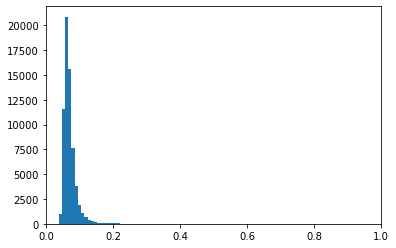

In [18]:
x=plt.hist(Seq2TfAff.values(),bins=100)
plt.xlim(0,1)

In [19]:
pvalCutoff=.05

deNovoThresh=.25

fcOptCutoff=1.5
fcDecCutoff=sf.round(1/fcOptCutoff,3)

fcNoChangeCutoff_Inc=1.25
fcNoChangeCutoff_Dec=sf.round(1/fcNoChangeCutoff_Inc,3)

logSigCutoff=abs(np.log10(pvalCutoff))

predDF=df.copy(deep=True)

# assign prediction labels
bins=[-np.inf,-logSigCutoff,logSigCutoff,np.inf]
predDF['classification']=pd.cut(predDF['-log(p)*direction'],bins=bins,labels=['Sig Decrease','N.S.','Sig Increase'])

# assign predictions
tfLabelsList=[]

# classes in which you only look at irf3 binding sites
onlyLookAtTfbsPos=[
    f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}',
    f'dramatic-increase\n>={fcOptCutoff}'
]

for posInTfbs,fc,classification,kmer,kmerMut in hf.zipdf(predDF,['pos-of-tfbs','aff-fc','variant-type','kmer-ref','kmer-alt']):

    # not in tf
    if classification=='Not In Tf':
        anno='not-in-tf'

    # delet tf
    elif classification=='Tf Deleted':
        anno='del-tf'

    elif classification=='Tf Created':

        denovoaff=Seq2TfAff[kmerMut]

        if denovoaff<deNovoThresh:
            anno=f'de-novo-tf-low-aff\n<{deNovoThresh}'            

        elif denovoaff>=deNovoThresh:
            anno=f'de-novo-tf-high-aff\n>={deNovoThresh}'

    #  dramatic increase
    elif fc>=fcOptCutoff and posInTfbs==True:
        anno=f'dramatic-increase\n>={fcOptCutoff}'

    #  dramatic decrease
    elif fc<=fcDecCutoff and posInTfbs==True:
        # print(fc,classification)
        anno=f'dramatic-decrease\n<={fcDecCutoff}'

    # no change
    elif fc<=fcNoChangeCutoff_Inc and fc>=fcNoChangeCutoff_Dec and posInTfbs==True:
        anno=f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'

    elif posInTfbs==False:
        anno='not-in-tf'
        
    else:
        # print(fc,classification,kmer,kmerMut)
        anno='subtle-change'

    tfLabelsList.append(anno)

predDF['tf-class']=tfLabelsList

line_out=hf.write_row(['snv-group','total','effect-ns','effect-gof','effect-lof'])

for classi in predDF['tf-class'].unique():
    nClassi=predDF['tf-class'].value_counts()[classi]
    
    if classi in onlyLookAtTfbsPos:
        ns,gof,lof=[predDF.loc[(predDF['tf-class']==classi) & (predDF['pos-of-tfbs']==True),'classification'].value_counts()[ci] for ci in ['N.S.','Sig Increase','Sig Decrease']]
    else:
        ns,gof,lof=[predDF.loc[(predDF['tf-class']==classi)                                ,'classification'].value_counts()[ci] for ci in ['N.S.','Sig Increase','Sig Decrease']]

    line_out+=hf.write_row([classi,nClassi,ns,gof,lof])

print(line_out)
with open(f'FOR-NATURE-STATS-PREDICTIONS-{tfName}__fdr.tsv','w') as f: f.write(line_out)

snv-group	total	effect-ns	effect-gof	effect-lof
de-novo-tf-low-aff
<0.25	7	4	1	2
de-novo-tf-high-aff
>=0.25	1	1	0	0
not-in-tf	50	28	4	18
del-tf	63	22	3	38
dramatic-increase
>=1.5	9	6	3	0
no-change-aff
<=1.25
>=0.8	9	7	0	2
dramatic-decrease
<=0.667	8	2	0	6
subtle-change	9	8	0	1



/Users/joe/miniconda3/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


dCtrl len 138
di len 9
dCtrl len 138
di len 9
group1	group2	p
not-in-tf+del-tf+dramatic-decrease <=0.667+de-novo-tf-low-aff <0.25+de-novo-tf-high-aff >=0.25+subtle-change	no-change-aff <=1.25 >=0.8	0.1392
not-in-tf+del-tf+dramatic-decrease <=0.667+de-novo-tf-low-aff <0.25+de-novo-tf-high-aff >=0.25+subtle-change	dramatic-increase >=1.5	0.000859



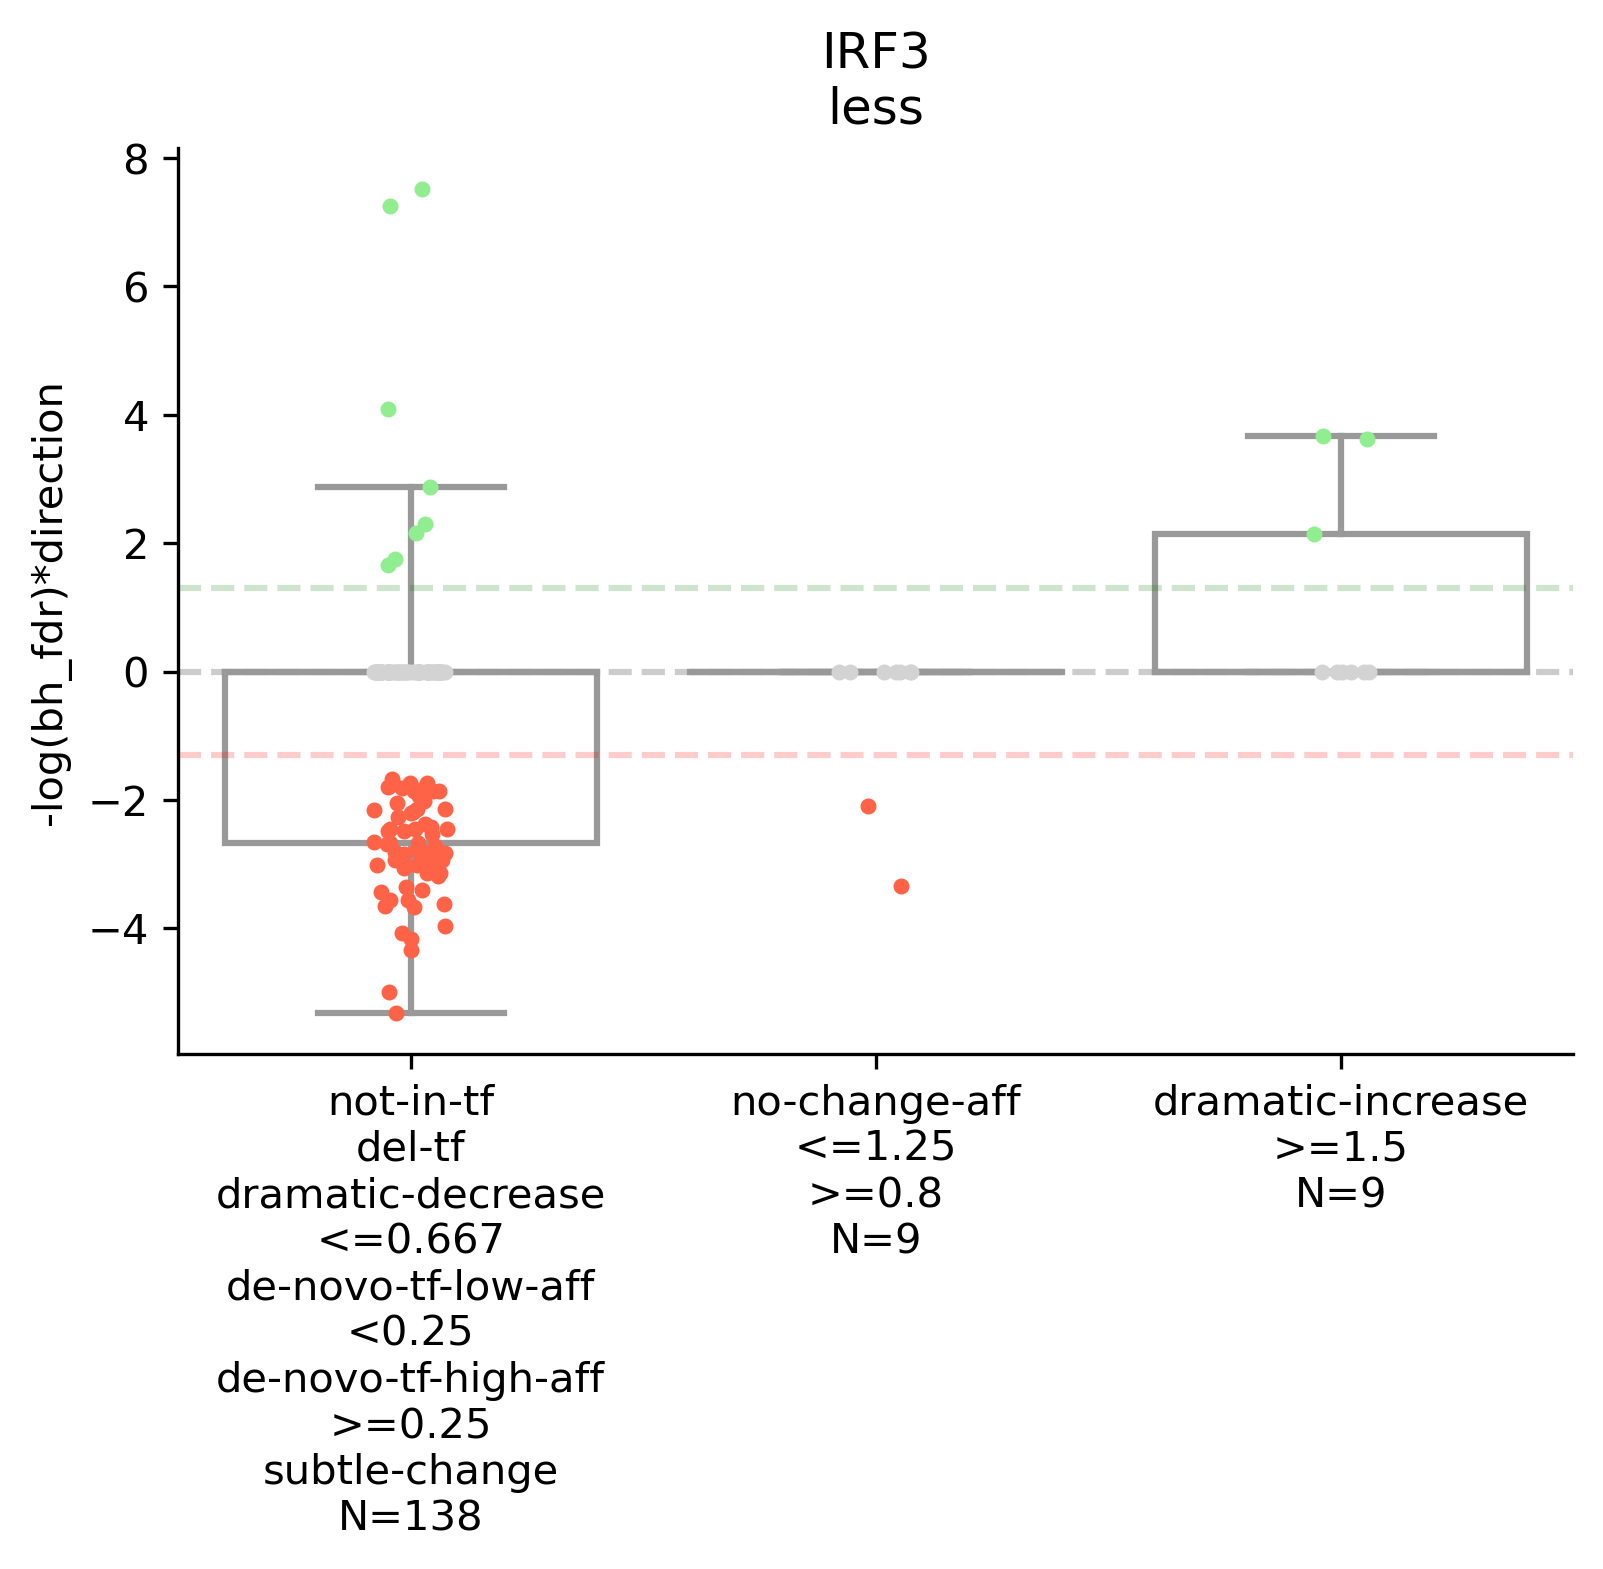

In [20]:
altHypothesis='less'
violin=False
boxplot=True

datalabels_subset_v2=[
[f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'],
[f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'],
[f'dramatic-increase\n>={fcOptCutoff}'],
]

data2color={
(f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}',):'lightgrey',
(f'dramatic-increase\n>={fcOptCutoff}',):'forestgreen',
(f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'):'dimgrey'}


plotDF=predDF.copy(deep=True)

data=[]
for di in datalabels_subset_v2:
    datai=[]
    for dj in di:
        if dj in onlyLookAtTfbsPos:
            datai+=plotDF.loc[(plotDF['tf-class']==dj) & (plotDF['pos-of-tfbs']==True),'-log(p)*direction'].tolist()
        else: 
            datai+=plotDF.loc[(plotDF['tf-class']==dj),                                '-log(p)*direction'].tolist()
    data.append(datai)

line_out=hf.write_row(['group1','group2','p'])

############################################################################
# Stats
############################################################################

dCtrlNameList=datalabels_subset_v2[0]
dCtrl=plotDF.loc[(plotDF['tf-class'].isin(dCtrlNameList)),'-log(p)*direction']

for diNameList in datalabels_subset_v2[1:]:

    di=plotDF.loc[(plotDF['tf-class'].isin(diNameList)) & (plotDF['pos-of-tfbs']==True),'-log(p)*direction']

    try:
        print('dCtrl len',len(dCtrl))
        print('di len',len(di))
        _ , p =stats.mannwhitneyu(dCtrl,di,alternative=altHypothesis)
    except ValueError:
        pass


    line_out+=hf.write_row(['+'.join(dCtrlNameList).replace('\n',' '),'+'.join(diNameList).replace('\n',' '),sf.round(p,4)])

print(line_out)
with open(f'FOR-NATURE__violin-stats__{tfName}.tsv','w') as f: f.write(line_out)

############################################################################
# plot
############################################################################

fig,ax=hf.quickfig(2*len(datalabels_subset_v2),4,dpi=300)

palette=[data2color[tuple(di)] for di in datalabels_subset_v2]

if violin:
    sns.violinplot(data=data,color='white',inner=None,cut=0,ax=ax,width=1.1,scale='area')

if boxplot:
    sns.boxplot(data=data,color='white',ax=ax,fliersize=0)#,palette=palette)

lc=0
for xi,di in enumerate(data):
    for lc, yi in enumerate(di):
        if lc>1000: break
        xjittermax=.08
        xijitter=np.random.uniform(-xjittermax,xjittermax)
        if yi>=logSigCutoff:            color='lightgreen'
        elif yi<=-logSigCutoff:          color='tomato'
        else:                           color='lightgrey'

        ax.scatter(xijitter+xi,yi, color=color,s=8,zorder=100,alpha=1)#,cut=0) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axticklabels=['\n'.join(label) for label in datalabels_subset_v2]
ax.set_xticklabels([f'{label}\nN={len(points):,}' for label,points in zip(axticklabels,data)])
ax.set_ylabel('-log(bh_fdr)*direction')

ax.axhline(-np.log10(.05),ls='--',color='green',alpha=.2)
ax.axhline(np.log10(.05),ls='--',color='red',alpha=.2)
ax.axhline(np.log10(1),ls='--',color='black',alpha=.2)

ax.set_title(f'{tfName}\n{altHypothesis}')

# plt.show()
plt.savefig("figure-5c.svg", format="svg")
  
        